In [3]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from lista import LISTA, make_loss
from functions import *
from copy import deepcopy

In [4]:
layers = np.linspace(1, 9, 5, dtype=int)

rng = np.random.RandomState(0)
n_samples = 1000
n_test = 1000
k = 100
p = 8
K = np.random.randn(p, p)
fit_loss = 'l2'
reg = None
architecture = 'sag'



fit_function, der_function = {
                              'l2': (l2_fit, l2_der),
                              'logreg': (logreg_fit, logreg_der)
                              }[fit_loss]
reg_function, prox = {
                      'l2': (l2_pen, l2_prox),
                      'l1': (l1_pen, l1_prox),
                      None: (no_pen, no_prox)
                      }[reg]
loss = make_loss(fit_function, reg_function)

z_true = rng.randn(p, n_samples)
D = rng.randn(k, p).dot(K)
D /= np.linalg.norm(D, axis=0, keepdims=True)

sigma = 0.1
eps = rng.randn(k, n_samples)

z_test = rng.randn(p, n_test)
eps_test = rng.randn(k, n_test)
X = np.dot(D, z_true) + eps
X_test = np.dot(D, z_test) + eps_test
if fit_loss == 'logreg':
    X = 2 * (X > 0) - 1
    X_test = 2 * (X_test > 0) - 1
lbda_max = np.max(np.abs(np.dot(D.T, X)))
lbda = 0.1 * lbda_max
print('lambda = %.2e' % lbda)

lambda = 7.06e-01


In [5]:
z = LISTA(D, lbda, 6, fit_loss, reg, variables='both', architecture='sag').compute_loss(X_test)
print(z)

46.27866679327273


In [6]:
ista_init = LISTA(D, lbda, 1, fit_loss, reg, variables='both', architecture=architecture)
ista_init.fit(X, l_rate=0.05, max_iter=3000, verbose=100)
init_weights = ista_init.weights

it 0, loss = 4.850e+01, grad_W = 2.81e+00, grad_l = 0.00e+00, l_rate = 5.00e-02


/home/pierre/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in add
  return f_raw(*args, **kwargs)


it 100, loss = nan, grad_W = nan, grad_l = 0.00e+00, l_rate = 5.00e-02


KeyboardInterrupt: 

In [5]:
ista = LISTA(D, lbda, 100000, fit_loss, reg)
L = ista.L
z_hat = ista.transform(X_test)
f_min = loss(z_hat, X_test, D, lbda)

print(np.linalg.norm(z_hat - prox(z_hat - np.dot(D.T / L, der_function(np.dot(D, z_hat), X_test)), lbda / L)))
print(f_min)

0.015342274260247644
0.05101252565402757


In [9]:
L_LIST = {}
for variables in ['both']:
    loss_list = {'ista': [], 'lista': []}
    for j, n_layers in enumerate(layers):
        print('%d layers' % n_layers)
        lista = LISTA(D, lbda, n_layers, fit_loss, reg, variables=variables,
                      learn_levels=True, architecture=architecture)
        if 0:
            lista.weights[:2] = init_weights
        loss_ista = lista.compute_loss(X_test)
        loss_list['ista'].append(loss_ista)
        # smart init
        if j > 0:
            lista.weights[:len(old_weights)] = old_weights
            lista.levels[:len(old_levels)] = old_levels
        lista.fit(X, l_rate=0.005, max_iter=101, backtrack=True, verbose=10, thres=0, l_rate_min=1e-10)
        loss_lista = lista.compute_loss(X_test)
        loss_list['lista'].append(loss_lista)
        print('Gain = %d percent' % (100 * (loss_ista - f_min) / (loss_lista - f_min) - 100))
        old_weights = deepcopy(lista.weights)
        old_levels = deepcopy(lista.levels)
    L_LIST[variables] = loss_list

1 layers
it 0, loss = 6.552e+00, grad_W = 1.47e+00, grad_l = 0.00e+00, l_rate = 5.00e-03
it 10, loss = 4.270e+00, grad_W = 7.18e-01, grad_l = 0.00e+00, l_rate = 5.12e+00
it 20, loss = 3.460e+00, grad_W = 7.41e-01, grad_l = 0.00e+00, l_rate = 2.56e+00
it 30, loss = 3.243e+00, grad_W = 1.25e+00, grad_l = 0.00e+00, l_rate = 6.40e-01
it 40, loss = 3.078e+00, grad_W = 1.32e+00, grad_l = 0.00e+00, l_rate = 2.56e+00
it 50, loss = 3.021e+00, grad_W = 6.35e-01, grad_l = 0.00e+00, l_rate = 6.40e-01
it 60, loss = 2.966e+00, grad_W = 1.77e+00, grad_l = 0.00e+00, l_rate = 6.40e-01
it 70, loss = 2.922e+00, grad_W = 5.42e-01, grad_l = 0.00e+00, l_rate = 6.40e-01
it 80, loss = 2.888e+00, grad_W = 1.43e+00, grad_l = 0.00e+00, l_rate = 6.40e-01
it 90, loss = 2.850e+00, grad_W = 5.51e-01, grad_l = 0.00e+00, l_rate = 6.40e-01
it 100, loss = 2.822e+00, grad_W = 1.29e+00, grad_l = 0.00e+00, l_rate = 6.40e-01
Gain = 139 percent
3 layers
it 0, loss = 4.497e+00, grad_W = 8.43e+00, grad_l = 0.00e+00, l_rate = 5

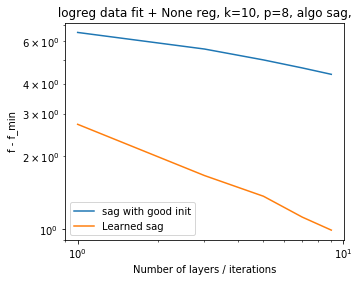

In [10]:
plt.figure(figsize=(5, 4))
title = ' %s data fit + %s reg, k=%d, p=%d, algo %s, ' % (fit_loss, reg, k, p, architecture)
plt.title(title)
plt.plot(layers, np.array(loss_list['ista']) - f_min, label='%s with good init' % architecture)
plt.plot(layers, np.array(L_LIST['both']['lista']) - f_min, label='Learned %s' % architecture)
plt.xlabel('Number of layers / iterations')
plt.ylabel('f - f_min')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(title + '.pdf')
plt.show()

In [2]:
weights = old_weigths

NameError: name 'old_weigths' is not defined